## Description

This is the most basic ABM simulation. Here, we have 1 DCAAgent, which:
 1. Onboards a constant amount of power daily to the network.
     a. Of the onboarded power, a constant amount is FIL+ data.
 2. Renews a constant amount of expiring power on the network

The purpose of this experiment is to establish a baseline upon which we will
build up additional experiments to test the robustness of Filecoin KPIs to 
network heterogeneity.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.agents.dca_agent import DCAAgent
from agentfil import constants
from mechafil import minting, sim

import numpyro

In [3]:
auth_token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

NDEVICES=2
numpyro.set_host_device_count(NDEVICES)

simulation_start_date = datetime.today().date() - timedelta(days=1)
forecast_length = 1080
end_date = simulation_start_date + timedelta(days=forecast_length)

num_agents = 1
agent_power_distributions = [1]   # 100% of the power is modeled with this agent

In [13]:
agent_types = [DCAAgent] * num_agents
agent_kwargs_vec = []
random_seed_base=1000
rng = np.random.RandomState(random_seed_base)

mean_pow = 10  # 3 PiB/day of RBP
std_pow = 0.5
renewal_rate = 0.6
fil_plus_rate = 0.6
for ii in range(num_agents):
    kwargs = {
        'max_daily_rb_onboard_pib': mean_pow,
        'renewal_rate': renewal_rate,
        'fil_plus_rate': fil_plus_rate,
        'sector_duration': 360
    }
    agent_kwargs_vec.append(kwargs)

minting_process_kwargs = {
    'forecast_history': 180,
    'update_every_days': 90,
    'num_warmup_mcmc': 500,
    'num_samples_mcmc': 500,
    'seasonality_mcmc': 1000,
    'num_chains_mcmc': 2,
    'verbose': False,
    'keep_previous_predictions': False,
    'keep_power_predictions': True,   # Setting this to true enables debugging plots but slows down simulation
}
price_process_kwargs = {
    'forecast_num_mc':1000,
    'random_seed':1234
}
fil_supply_discount_rate_process_kwargs = {
    'min_discount_rate_pct':0, 
    'max_discount_rate_pct':200,
    'start_discount_rate_pct':25,
    'behavior':'constant',
    'seed':1234
}

filecoin_model = FilecoinModel(num_agents, simulation_start_date, end_date, 
                               spacescope_cfg=auth_token,
                               agent_types=agent_types, agent_kwargs_list=agent_kwargs_vec, 
                               agent_power_distributions=agent_power_distributions,
                               compute_cs_from_networkdatastart=True, use_historical_gas=False,
                               price_process_kwargs=price_process_kwargs,
                               minting_process_kwargs=minting_process_kwargs,
                               fil_supply_discount_rate_process_kwargs=fil_supply_discount_rate_process_kwargs)

/opt/anaconda3/envs/agentfil/lib/python3.10/site-packages/mechafil/data.py:151: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[
/opt/anaconda3/envs/agentfil/lib/python3.10/site-packages/mechafil/data.py:168: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  date_df = df[df["date"] >= pd.to_datetime(date, utc="UTC")]


Fast forwarding power to simulation start date... 2023-03-29
Computing Scheduled Expirations from:  2023-03-29  to:  2024-09-18
Initializing circulating supply...
Updating circulating supply statistics...
Computing initial generated quantities...


/opt/anaconda3/envs/agentfil/lib/python3.10/site-packages/mechafil/data.py:151: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[


In [14]:
sim_len = (end_date - simulation_start_date).days
for ii in tqdm(range(sim_len)):
    filecoin_model.step()

  0%|          | 0/1080 [00:00<?, ?it/s]

In [15]:
# setup for plotting the outputs
forecasts_df = filecoin_model.global_forecast_df
update_dates = filecoin_model.minting_process.update_dates
model_df = filecoin_model.filecoin_df
model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]

# agent plotting helper functions
def plot_agent(keys, post_process=None, agent_idxs_to_plot=None, df_name='agent_info_df',
               x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=None):
    if post_process is None:
        post_fn = lambda x: x
    else:
        post_fn = post_process
    
    # defaults to plotting all agents
    for ii, agent_dict in enumerate(filecoin_model.agents):
        if agent_idxs_to_plot is None or ii in agent_idxs_to_plot:
            agent_handle = agent_dict['agent']
            agent_df = getattr(agent_handle, df_name)
            l = label_prepend + '-Agent%d' % (ii,) + '-' + label_postpend
            plot_kwargs = plot_kwargs_list[ii] if plot_kwargs_list is not None else {}
            if len(keys)==1:
                k = keys[0]
                y = post_fn(agent_df[k])
                plt.plot(agent_df[x_key], y, label=l, **plot_kwargs)
            else:
                # get all keys and call the combine function
                key_data = {}
                for k in keys:
                    key_data[k] = agent_df[k]
                y = post_fn(key_data)
                plt.plot(agent_df[x_key], y, label=l, **plot_kwargs)
            plt.xticks(rotation=60)

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_15496/283819369.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]


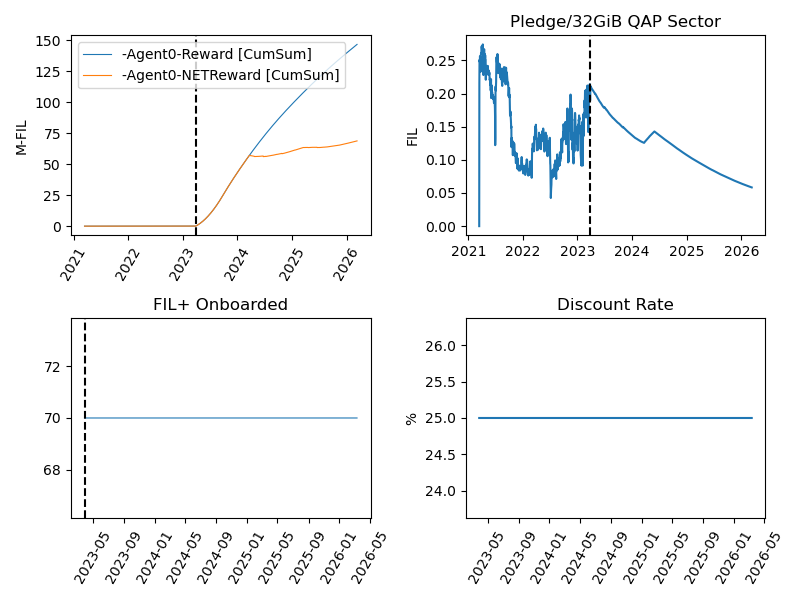

In [16]:
plt_kwargs = [{'linewidth': 0.8}] * num_agents
post_process_2MFIL = lambda x: x.cumsum()/1_000_000

plt.figure(figsize=(8,6))

plt.subplot(2,2,1)

plot_agent(['reward_FIL'], post_process=post_process_2MFIL, 
           df_name='accounting_df', 
           label_postpend='Reward [CumSum]', 
           plot_kwargs_list=plt_kwargs)
plt.axvline(simulation_start_date, linestyle='--', color='k')

keys = ['reward_FIL', 'pledge_interest_payment_FIL']
def compute_net_reward_FIL(key_data):
    net_reward_FIL = key_data['reward_FIL'].cumsum() - key_data['pledge_interest_payment_FIL'].cumsum()
    return net_reward_FIL/1_000_000
plot_agent(keys, post_process=compute_net_reward_FIL, 
           df_name='accounting_df', 
           label_postpend='NETReward [CumSum]', 
           plot_kwargs_list=plt_kwargs)
plt.ylabel('M-FIL')
plt.legend()

plt.subplot(2,2,2)
plt.plot(model_df['date'], model_df['day_pledge_per_QAP'])
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('Pledge/32GiB QAP Sector')
plt.ylabel('FIL')


# plt.subplot(3,2,3)
# def compute_total_interest(key_data):
#     total_interest = key_data['pledge_repayment_FIL'] - key_data['pledge_requested_FIL']
#     return total_interest
# plot_agent(['pledge_requested_FIL', 'pledge_repayment_FIL'], 
#            post_process=compute_total_interest, 
#            df_name='accounting_df', 
#            plot_kwargs_list=plt_kwargs)
# plt.title('Total Interest Payment')
# plt.ylabel('FIL')

# plt.subplot(3,2,4)
# def compute_total_interest_cumsum(key_data):
#     total_interest = key_data['pledge_repayment_FIL'] - key_data['pledge_requested_FIL']
#     return total_interest.cumsum()/1_000_000
# plot_agent(['pledge_requested_FIL', 'pledge_repayment_FIL'], 
#            post_process=compute_total_interest_cumsum, 
#            df_name='accounting_df', 
#            plot_kwargs_list=plt_kwargs)
# plt.title('Agent Debt [CumSum]')
# plt.ylabel('M-FIL')

plt.subplot(2,2,3)
plot_agent(['deal_onboarded'], plot_kwargs_list=plt_kwargs)
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('FIL+ Onboarded')

plt.subplot(2,2,4)
plt.plot(model_df_simsubset['date'], model_df_simsubset['discount_rate_pct'])
# plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('Discount Rate')
plt.ylabel('%')
plt.xticks(rotation=60)

plt.tight_layout()

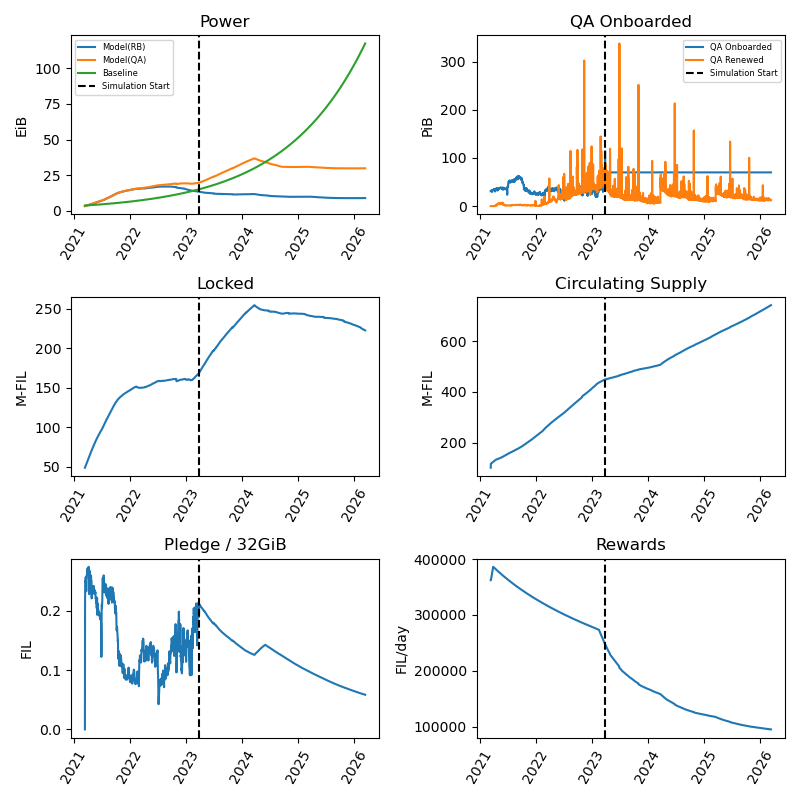

In [17]:
plt.figure(figsize=(8,8))
plt.subplot(3,2,1)
plt.plot(model_df['date'], model_df['total_raw_power_eib'], label='Model(RB)')
plt.plot(model_df['date'], model_df['total_qa_power_eib'], label='Model(QA)')
plt.plot(model_df['date'], model_df['network_baseline'] / 2**60, label='Baseline')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.legend(fontsize=6)
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('Power')

plt.subplot(3,2,2)
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'], label='QA Onboarded')
plt.plot(model_df['date'], model_df['day_renewed_qap_pib'], label='QA Renewed')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('QA Onboarded')
plt.ylabel('PiB')
plt.legend(fontsize=6)

plt.subplot(3,2,3)
plt.plot(model_df['date'], model_df['network_locked']/1_000_000)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Locked')

plt.subplot(3,2,4)
plt.plot(model_df['date'], model_df['circ_supply']/1_000_000)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Circulating Supply')

plt.subplot(3,2,5)
plt.plot(model_df['date'], model_df['day_pledge_per_QAP'])
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL')
plt.xticks(rotation=60)
plt.title('Pledge / 32GiB')

plt.subplot(3,2,6)
plt.plot(model_df['date'], model_df['day_network_reward'])
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL/day')
plt.xticks(rotation=60)
plt.title('Rewards')


plt.tight_layout()

plt.show()